<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/master/CONV1D_LSTM_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift= 1, drop_remainder =True)
  dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
  dataset = dataset.shuffle(shuffle_buffer_size)
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  return dataset.batch(batch_size).prefetch(1)

In [5]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer_size=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1,  padding='causal', activation='relu', input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x : x * 200)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss= tf.keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 36ms/step - loss: 73.6163 - mae: 74.1154
Epoch 2/100
8/8 [==============================] - 0s 28ms/step - loss: 72.8992 - mae: 73.3982
Epoch 3/100
8/8 [==============================] - 0s 28ms/step - loss: 71.7509 - mae: 72.2500
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 70.3121 - mae: 70.8111
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 68.6372 - mae: 69.1363
Epoch 6/100
8/8 [==============================] - 0s 27ms/step - loss: 66.6965 - mae: 67.1954
Epoch 7/100
8/8 [==============================] - 0s 28ms/step - loss: 64.5149 - mae: 65.0137
Epoch 8/100
8/8 [==============================] - 0s 27ms/step - loss: 62.0192 - mae: 62.5179
Epoch 9/100
8/8 [==============================] - 0s 28ms/step - loss: 59.1778 - mae: 59.6764
Epoch 10/100
8/8 [==============================] - 0s 26ms/step - loss: 55.8527 - mae: 56.3513
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

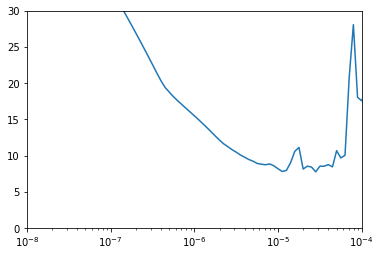

In [9]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 1s 16ms/step - loss: 21.9671 - mae: 22.4622
Epoch 2/500
31/31 [==============================] - 0s 15ms/step - loss: 10.9377 - mae: 11.4248
Epoch 3/500
31/31 [==============================] - 0s 15ms/step - loss: 10.0826 - mae: 10.5686
Epoch 4/500
31/31 [==============================] - 0s 15ms/step - loss: 9.4977 - mae: 9.9832
Epoch 5/500
31/31 [==============================] - 0s 15ms/step - loss: 9.2363 - mae: 9.7218
Epoch 6/500
31/31 [==============================] - 0s 16ms/step - loss: 9.0164 - mae: 9.5012
Epoch 7/500
31/31 [==============================] - 0s 15ms/step - loss: 8.9155 - mae: 9.4001
Epoch 8/500
31/31 [==============================] - 0s 16ms/step - loss: 9.1551 - mae: 9.6404
Epoch 9/500
31/31 [==============================] - 0s 15ms/step - loss: 8.8034 - mae: 9.2887
Epoch 10/500
31/31 [==============================] - 0s 15ms/step - loss: 8.5604 - mae: 9.0440
Epoch 11/500
31/31 [=======================

In [11]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

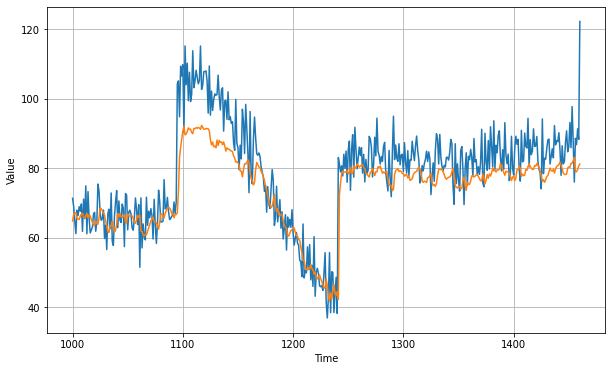

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

6.4936233

<Figure size 432x288 with 0 Axes>

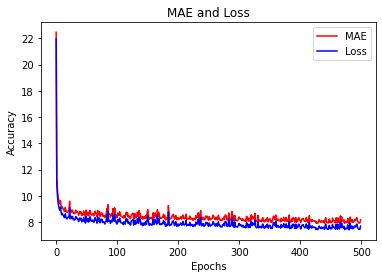

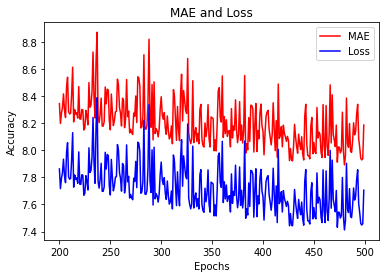

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()